In [19]:
# 라이브러리 호출
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [20]:
# 이미지 데이터 전처리 방법 정의
data_path = 'pytorch/data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

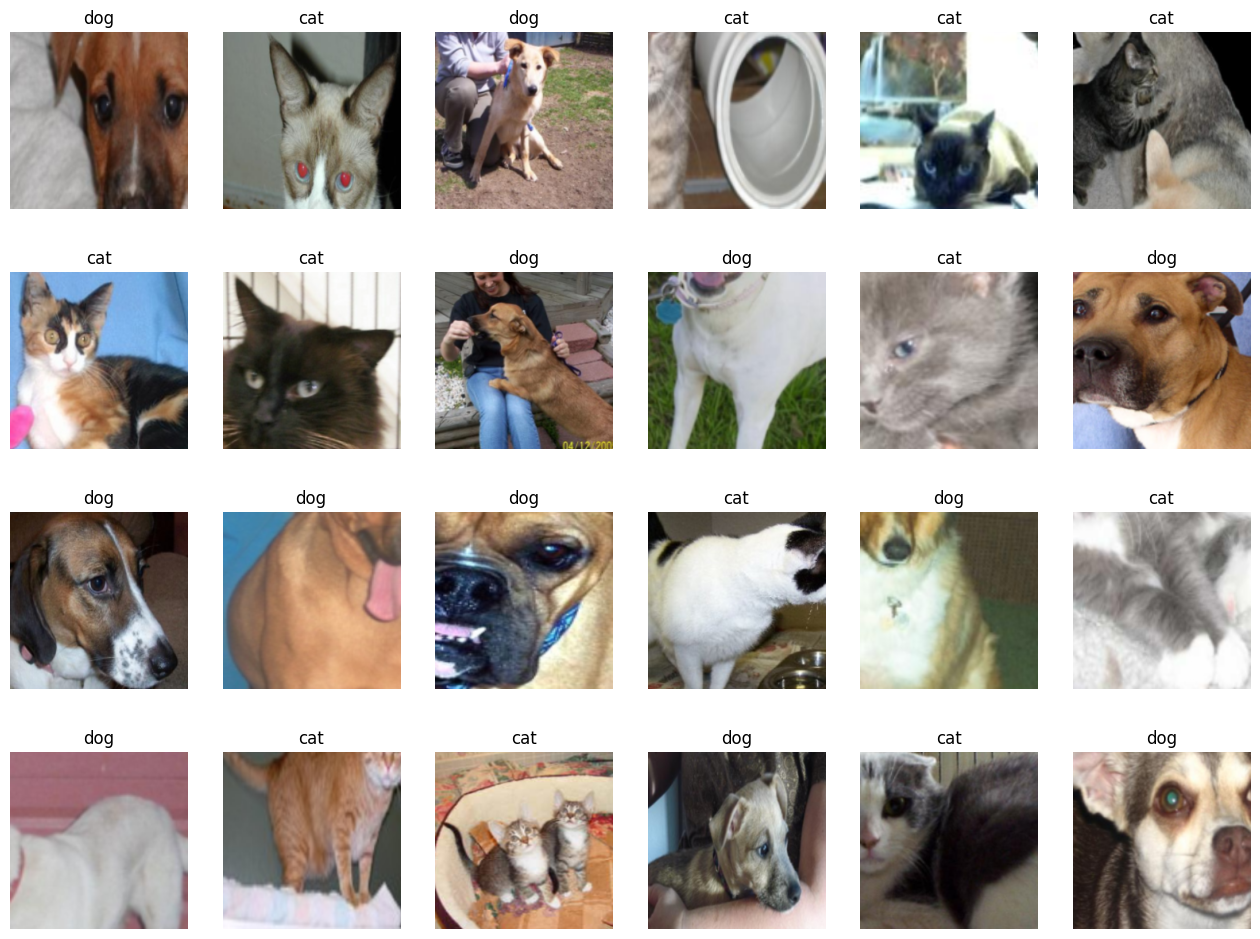

In [21]:
# 학습에 사용될 이미지 출력
samples, labels = next(iter(train_loader))
classes = {0 : 'cat', 1 : 'dog'}
fig = plt.figure(figsize=(16, 24))
for i in range(24):
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [22]:
# 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True)

In [23]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [24]:
# ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2)

In [25]:
# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0426, -0.0075,  0.0142,  ...,  0.0349,  0.0393,  0.0058],
        [-0.0139,  0.0313, -0.0288,  ..., -0.0029, -0.0023,  0.0270]])
fc.bias tensor([-0.0374,  0.0267])


In [26]:
# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 2)
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters())
cost = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print("Loss : {:.4f} Acc : {:.4f}".format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join("pytorch/data/catanddog/", "{0:0=2d}.pth".format(epoch)))
        print()

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best Acc : {:.4f}".format(best_acc))
    return acc_history, loss_history

In [28]:
# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True: 
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [29]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss : 0.7492 Acc : 0.5273

Epoch 1/12
----------
Loss : 0.5024 Acc : 0.7948

Epoch 2/12
----------
Loss : 0.3932 Acc : 0.8364

Epoch 3/12
----------
Loss : 0.3604 Acc : 0.8468

Epoch 4/12
----------
Loss : 0.2698 Acc : 0.9091

Epoch 5/12
----------
Loss : 0.2763 Acc : 0.8909

Epoch 6/12
----------
Loss : 0.2434 Acc : 0.9013

Epoch 7/12
----------
Loss : 0.2093 Acc : 0.9377

Epoch 8/12
----------
Loss : 0.2626 Acc : 0.8909

Epoch 9/12
----------
Loss : 0.3242 Acc : 0.8468

Epoch 10/12
----------
Loss : 0.2166 Acc : 0.9169

Epoch 11/12
----------
Loss : 0.1972 Acc : 0.9143

Epoch 12/12
----------
Loss : 0.1918 Acc : 0.9143

Training complete in 1m 48s
Best Acc : 0.9377


In [30]:
# 테스트 데이터 호출 및 전처리
test_path = "pytorch/data/catanddog/test"

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True)

print(len(test_dataset))

98


In [31]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob("pytorch/data/catanddog/" + "*.pth")
    saved_models.sort()
    print("saved_model", saved_models)

    for model_path in saved_models:
        print("Loading model", model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print("Acc : {:.4f}".format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            acc_history.append(epoch_acc.item())
            print()
        
    time_elapsed = time.time() - since
    print("Validation complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best Acc : {:.4f}".format(best_acc))

    return acc_history

In [32]:
# 테스트 데이터를 평가 함수애 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['pytorch/data/catanddog\\00.pth', 'pytorch/data/catanddog\\01.pth', 'pytorch/data/catanddog\\02.pth', 'pytorch/data/catanddog\\03.pth', 'pytorch/data/catanddog\\04.pth', 'pytorch/data/catanddog\\05.pth', 'pytorch/data/catanddog\\06.pth', 'pytorch/data/catanddog\\07.pth', 'pytorch/data/catanddog\\08.pth', 'pytorch/data/catanddog\\09.pth', 'pytorch/data/catanddog\\10.pth', 'pytorch/data/catanddog\\11.pth', 'pytorch/data/catanddog\\12.pth']
Loading model pytorch/data/catanddog\00.pth
Acc : 0.6224

Loading model pytorch/data/catanddog\01.pth
Acc : 0.9388

Loading model pytorch/data/catanddog\02.pth
Acc : 0.9286
Loading model pytorch/data/catanddog\03.pth
Acc : 0.9286
Loading model pytorch/data/catanddog\04.pth
Acc : 0.9184
Loading model pytorch/data/catanddog\05.pth
Acc : 0.9490

Loading model pytorch/data/catanddog\06.pth
Acc : 0.9286
Loading model pytorch/data/catanddog\07.pth
Acc : 0.9694

Loading model pytorch/data/catanddog\08.pth
Acc : 0.9694
Loading model pytorch/data/c

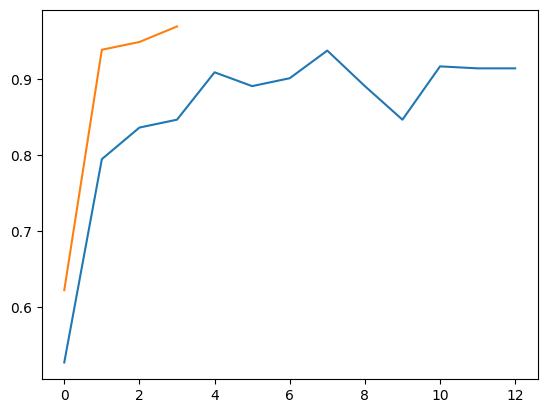

In [33]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
# Blue
plt.plot(train_acc_hist)
# Orange
plt.plot(val_acc_hist)
plt.show()

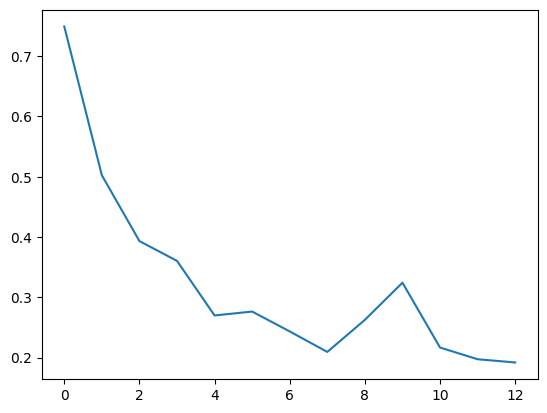

In [34]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [35]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image

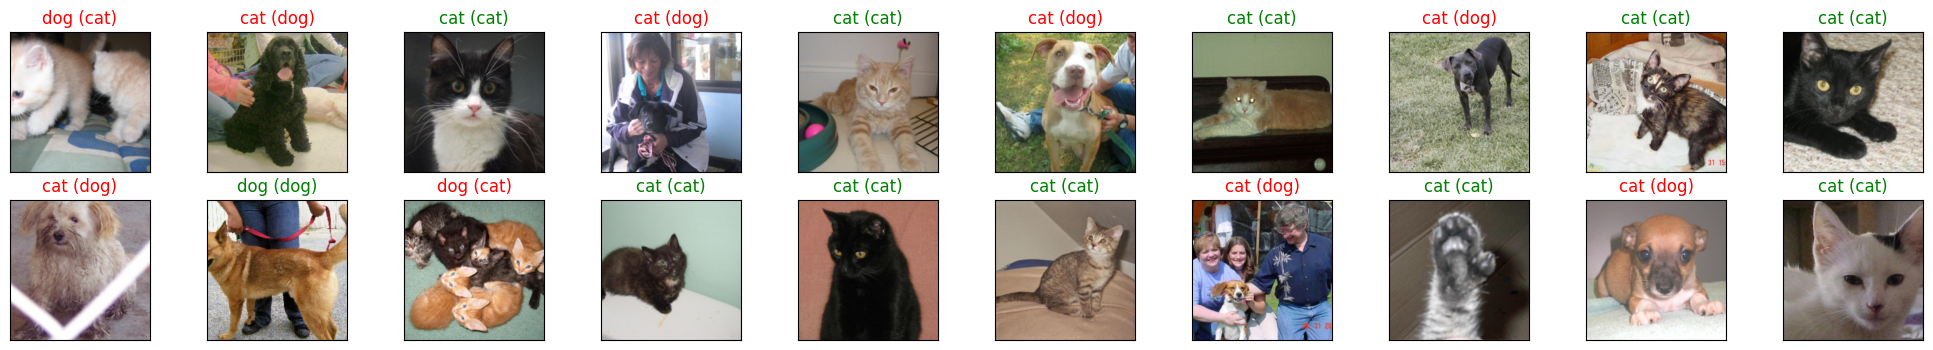

<Figure size 640x480 with 0 Axes>

In [36]:
# 개와 고양이 예측 결과 출력
classes = {0 : "cat", 1 : "dog"}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                color=("green" if preds[idx] == labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)